# Streaming 
In this exercise we want to test our keyword spotter on self recorded wav files containing some keywords. 

In [1]:
import os
import tensorflow as tf
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from utility import smoothing, augment_audio

2022-05-02 13:51:54.313875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 13:51:54.313985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Pre-trained model

In [4]:
## Load a pretrained model, you should choose a good one here out of the ones you have trained
checkpoint_path = './output/2022_05_02_13_29_15/saved_models/' #'./output/2021_08_23_13_42_20/saved_models/'

In [5]:
## Load the model
if os.path.isdir(checkpoint_path):
    model = tf.keras.models.load_model(checkpoint_path)
    print('model loaded successfully')
else:
    print('could not find model')

2022-05-02 13:52:25.867255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 13:52:25.867287: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 13:52:25.867311: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nm-hekate): /proc/driver/nvidia/version does not exist
2022-05-02 13:52:25.867539: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


model loaded successfully


In [6]:
# Print summary of trained model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 49, 1, 40)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 49, 1, 16)         1920      
                                                                 
 dropout_12 (Dropout)        (None, 49, 1, 16)         0         
                                                                 
 res_block_6 (ResBlock)      (None, 25, 1, 24)         9312      
                                                                 
 dropout_13 (Dropout)        (None, 25, 1, 24)         0         
                                                                 
 res_block_7 (ResBlock)      (None, 25, 1, 24)         10560     
                                                                 
 dropout_14 (Dropout)        (None, 25, 1, 24)        

### Deployment of keyword spotter

In [7]:
## Applying the kws to a given 1s audio chunk of data and returns a dictionary with the calculated scores
def apply_spotter(data=[], model=model):
    assert len(data)==fs
    mfccs = augment_audio(mode='',sig=data, fs=fs, l=l, s=s, n_mfccs=n_mfccs).reshape(1,49,40)
    prediction = model.predict(mfccs)[0]
    return {k:prediction[i] for i,k in enumerate(kws_all)}

In [9]:
## Load a recording containing some keywords. I provided this one but its more fun to try on your own recording
## I said: yes, no, what am I doing, go with short breaks in between
path_to_recording = './media/test.wav'

audio = librosa.load(path_to_recording, sr=16000)[0]
ipd.Audio(audio, rate=16000)


In [10]:
## Divide the stream into chunks to simulate real streaming
chunksize = 4000

audio_chunked = np.array([ audio[i*chunksize:(i+1)*chunksize] for i in range(0,len(audio)//chunksize)] )
audio_chunked.shape

(33, 4000)

## Exercise

1. Create a $1s$ long audio array. For each chunk in audio_chunked, update the $1s$ long audio array and pass it to the apply_spotter function to evaluate the keyword spotter. Save the resulting probability scores into a vector "all_scores". Each entry of "all_scores" should contain $12$ probabilities, one for each keyword.
2. Plot the probabilities for all classes over time. How would you decide when a keyword was said based on the scores?
3. Understand what the smoothing function above does and use it to smooth the "all_scores" vector. Visualize the smoothed results. Are they better? Why?
4. Execute the notebook again, but with your own recording. You can use **audacity** to create a $.wav$ file. 

## Hints

- Think about how you need to adjust the $1s$ long audio snippet each time a new chunk arrives.

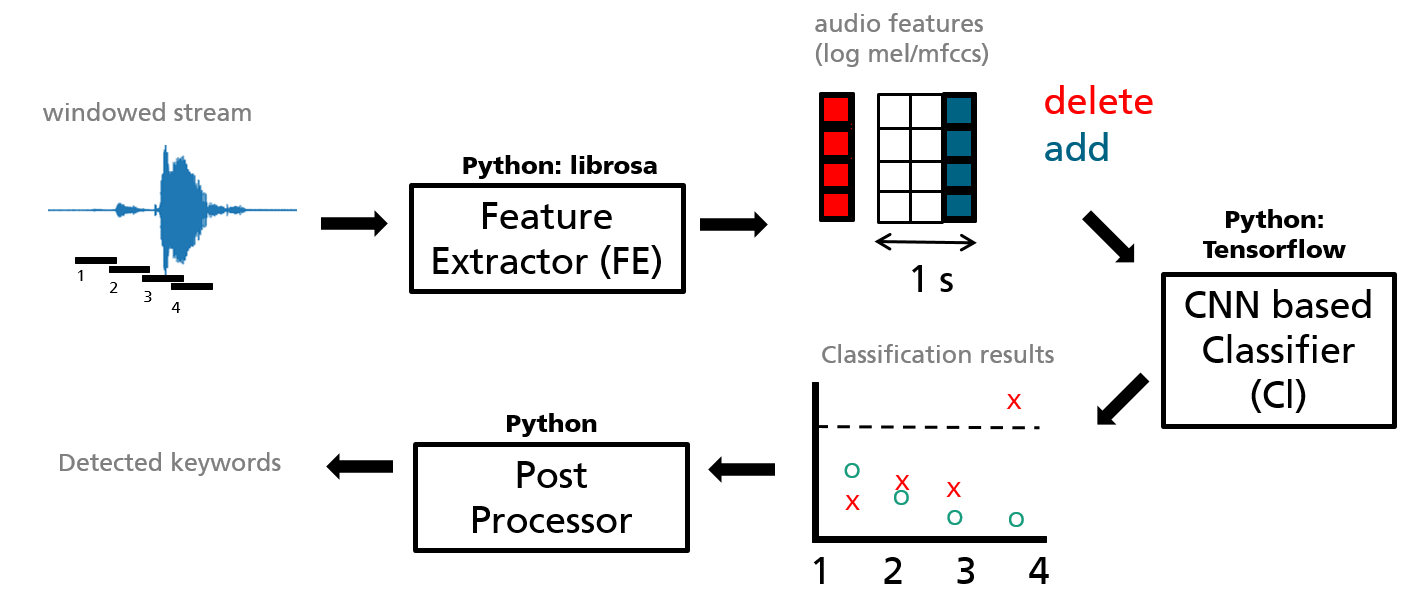

In [12]:
ipd.Image('./media/streaming_kws.png')

## Solution

### E1

We drop the oldest chunk (left part of the input vector) and append the new chunk.

In [13]:
## Apply the model to the audio stream
audio_1s = np.zeros(16000)
all_scores = []

for chunk in audio_chunked:
    
    ## Throw out the oldest chunk
    audio_1s[0:16000-chunksize] = audio_1s[chunksize:]
    
    ## Append the latest chunk
    audio_1s[16000-chunksize:] = chunk
    
    ## Apply the spotter
    scores = apply_spotter(audio_1s)
    
    ## Save scores for plotting
    all_scores.append([scores[key] for key in scores])

/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00122691 -0.00116729
 -0.00053748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[0.         0.         0.         ... 0.00054794 0.00089325 0.0021495 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[0.         0.         0.         ... 0.00121009 0.00111046 0.00018111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.fea

/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[0.00098904 0.00135546 0.00143693 ... 0.00184332 0.00156327 0.00231533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[2.14921820e-04 5.26462740e-04 5.11517865e-04 ... 1.36819929e-01
 1.87845021e-01 2.24140391e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feat = librosa.feature.mfcc(sig, win_length=lprime, n_mfcc=n_mfccs, sr=fs, n_fft=lprime, hop_length=hprime,
/nm-raid/nishome/pwallbott/code/medium_2022/utility.py:124: FutureWarning: Pass y=[ 0.00169542  0.00157935  0.00100236 ... -0.00398121 -0.00450397
 -0.00522564] as keyword args. From version 0.10 passing these as positional arguments will result in an e

### E2 &  E3
We use a threshold whose value balances between false positives and false negatives. The problem is, there are some high but small width peaks that are obviously wrong. To avoid a false positive we also use the width of the peaks to decide wether a keyword was spoken. For example, this can  be done by using the area under the curve over a fixed amount of past time frames. The result (fig. 2) shows, that the narrow peaks can now be avoided by choosing a high enough threshold.

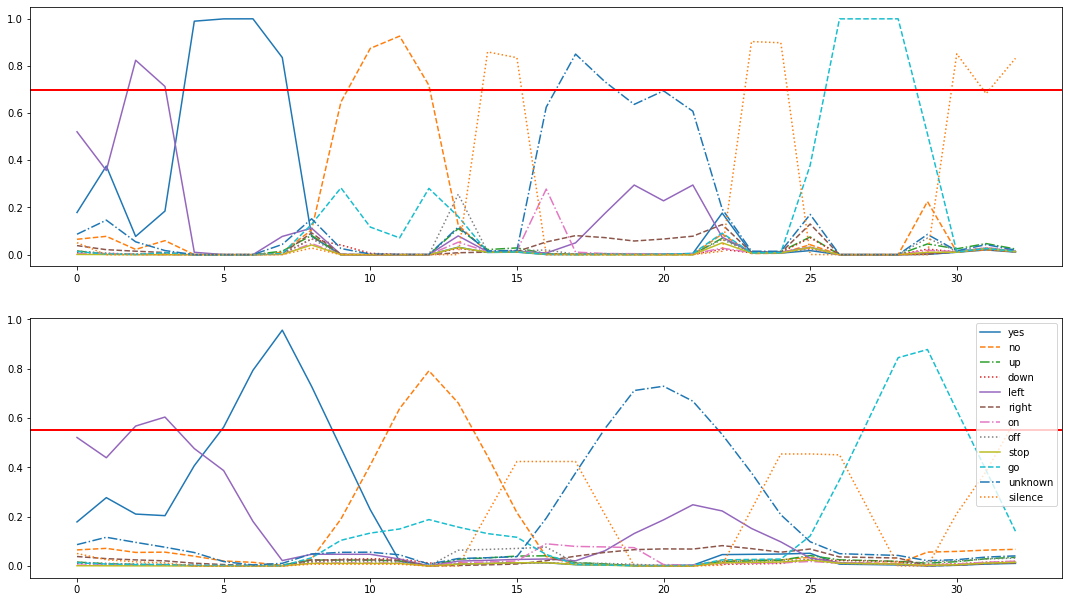

In [14]:
## plot the output probabilities
smoothing_level = 4

colors = ['red', 'green', 'blue', 'black', 'orange', 'brown', 'yellow', 'red', 'green', 'blue', 'black']
lines = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]

fig, axs = plt.subplots(2,)
fig.set_size_inches(18.5, 10.5)

hw_prob_smoothed = np.array(all_scores)

for i in range(len(hw_prob_smoothed[0])):
    axs[0].plot(hw_prob_smoothed[:,i], linestyle=lines[i])
    axs[0].axhline(y=.7, color='r')    
    
    axs[1].plot(smoothing(hw_prob_smoothed, smoothing_level)[:,i], label=kws_all[i], linestyle=lines[i])
    axs[1].axhline(y=.55, color='r')    

plt.legend()

In [15]:
ipd.Audio(audio, rate=16000)